# **1. Import Libraries**

In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    classification_report,
    confusion_matrix
)

# Ensure reproducibility
SEED_VALUE = 42
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

print("✅ Libraries imported and random seeds set.")

✅ Libraries imported and random seeds set.


# **2. Load NASA C-MAPSS Dataset**

In [3]:
import kagglehub
behrad3d_nasa_cmaps_path = kagglehub.dataset_download('behrad3d/nasa-cmaps')

cmaps_path = os.path.join(behrad3d_nasa_cmaps_path, "CMaps")

# Define columns
columns = [
    "engine_id", "time_in_cycles",
    "op_setting_1", "op_setting_2", "op_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

# Load files
train_df = pd.read_csv(os.path.join(cmaps_path, "train_FD001.txt"),
                       sep=r"\s+", header=None, names=columns)
test_df = pd.read_csv(os.path.join(cmaps_path, "test_FD001.txt"),
                      sep=r"\s+", header=None, names=columns)
rul_df = pd.read_csv(os.path.join(cmaps_path, "RUL_FD001.txt"),
                     header=None, names=["RUL"])

print("✅ Data loaded successfully.")
print(train_df.head())


Using Colab cache for faster access to the 'nasa-cmaps' dataset.
✅ Data loaded successfully.
   engine_id  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0          1               1       -0.0007       -0.0004         100.0   
1          1               2        0.0019       -0.0003         100.0   
2          1               3       -0.0043        0.0003         100.0   
3          1               4        0.0007        0.0000         100.0   
4          1               5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    518.67    641.82   1589.70   1400.60     14.62  ...     521.66   
1    518.67    642.15   1591.82   1403.14     14.62  ...     522.28   
2    518.67    642.35   1587.99   1404.20     14.62  ...     522.42   
3    518.67    642.35   1582.79   1401.87     14.62  ...     522.86   
4    518.67    642.37   1582.85   1406.22     14.62  ...     522.19   

   sensor_13  sensor_14  sensor_15 

# **3. Exploratory Data Analysis (EDA)**

Train shape: (20631, 26), Test shape: (13096, 26), RUL shape: (100, 1)
          engine_id  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
count  20631.000000    20631.000000  20631.000000  20631.000000       20631.0   
mean      51.506568      108.807862     -0.000009      0.000002         100.0   
std       29.227633       68.880990      0.002187      0.000293           0.0   
min        1.000000        1.000000     -0.008700     -0.000600         100.0   
25%       26.000000       52.000000     -0.001500     -0.000200         100.0   
50%       52.000000      104.000000      0.000000      0.000000         100.0   
75%       77.000000      156.000000      0.001500      0.000300         100.0   
max      100.000000      362.000000      0.008700      0.000600         100.0   

           sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.

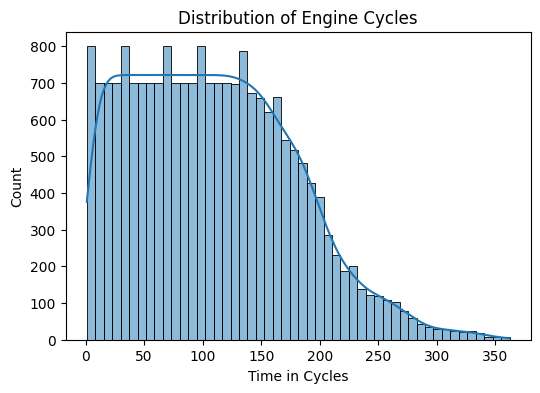

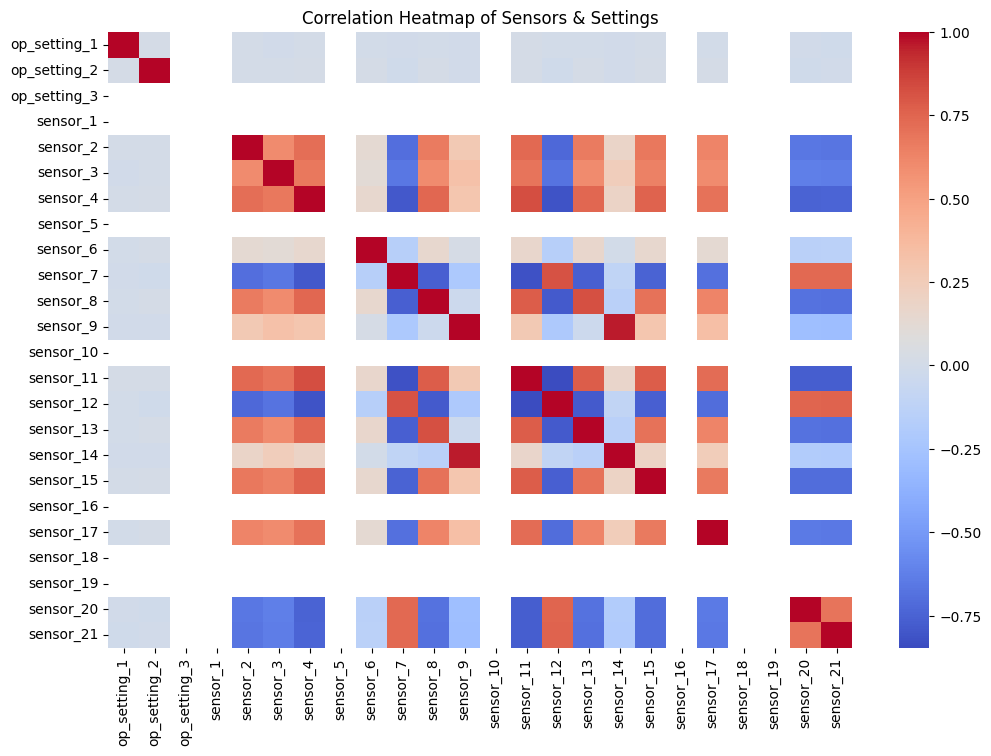

In [4]:
# Check dataset dimensions
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}, RUL shape: {rul_df.shape}")

# Basic statistics
print(train_df.describe())

# Plot RUL distribution after engineering
plt.figure(figsize=(6,4))
sns.histplot(train_df['time_in_cycles'], bins=50, kde=True)
plt.title("Distribution of Engine Cycles")
plt.xlabel("Time in Cycles")
plt.ylabel("Count")
plt.show()

# Sensor correlations
plt.figure(figsize=(12,8))
sns.heatmap(train_df.drop(columns=["engine_id","time_in_cycles"]).corr(),
            cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Sensors & Settings")
plt.show()

# **4. Feature Engineering & Preprocessing**

In [5]:
# Drop constant columns
constant_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
train_df.drop(columns=constant_cols, inplace=True)
test_df.drop(columns=constant_cols, inplace=True)

# Compute max cycles for RUL
max_cycles_df = train_df.groupby('engine_id')['time_in_cycles'].max().reset_index()
max_cycles_df.columns = ['engine_id', 'max_cycles']
train_df = pd.merge(train_df, max_cycles_df, on='engine_id', how='left')

# Compute RUL
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']
train_df.drop(columns=['max_cycles'], inplace=True)

# Cap RUL at 125
train_df['RUL'] = train_df['RUL'].clip(upper=125)

# Scale features
feature_cols = train_df.columns.drop(['engine_id', 'time_in_cycles', 'RUL'])
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

print("✅ Feature engineering & preprocessing complete.")

✅ Feature engineering & preprocessing complete.


# **5. Sequence Generation for LSTM**

In [6]:
def generate_sequences(df, sequence_length, feature_cols):
    """Generate LSTM sequences with RUL targets."""
    sequences, targets = [], []
    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id]
        for i in range(len(engine_df) - sequence_length + 1):
            seq = engine_df[feature_cols].iloc[i:i+sequence_length].values
            target = engine_df['RUL'].iloc[i+sequence_length-1]
            sequences.append(seq)
            targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 50
X_train_lstm, y_train_lstm = generate_sequences(train_df, sequence_length, feature_cols)

# Test sequences (last cycles)
X_test_lstm = []
for engine_id in test_df['engine_id'].unique():
    engine_df = test_df[test_df['engine_id'] == engine_id]
    last_seq = engine_df[feature_cols].tail(sequence_length).values
    if len(last_seq) < sequence_length:
        padded_seq = np.zeros((sequence_length, len(feature_cols)))
        padded_seq[-len(last_seq):] = last_seq
        X_test_lstm.append(padded_seq)
    else:
        X_test_lstm.append(last_seq)
X_test_lstm = np.array(X_test_lstm)
y_test_lstm = rul_df['RUL'].values

print(f"✅ Sequences generated: Train {X_train_lstm.shape}, Test {X_test_lstm.shape}")

✅ Sequences generated: Train (15731, 50, 17), Test (100, 50, 17)


# **6. Build & Train LSTM Model**



In [7]:
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Determine the input shape from our training data (sequence_length, num_features)
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build the LSTM model
lstm_model = Sequential()

# Add the explicit Input layer
# lstm_model.add(Input(shape=input_shape))
lstm_model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
lstm_model.add(Dropout(0.3))

# First LSTM layer with Dropout
lstm_model.add(LSTM(64, return_sequences=True,activation='tanh'))
lstm_model.add(Dropout(0.3))

# Second LSTM layer with Dropout
lstm_model.add(LSTM(units=32, activation='tanh'))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(1))


# Display the model's architecture
lstm_model.summary()

lstm_model.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

print("✅ Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        74,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,753 (542.00 KB)

 Trainable params: 138,753 (542.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
394/394 - 56s - 141ms/step - loss: 2626.4883 - root_mean_squared_error: 51.2493 - val_loss: 1838.8556 - val_root_mean_squared_error: 42.8819
Epoch 2/100
394/394 - 83s - 211ms/step - loss: 1767.0862 - root_mean_squared_error: 42.0367 - val_loss: 1848.3007 - val_root_mean_squared_error: 42.9919
Epoch 3/100
394/394 - 47s - 120ms/step - loss: 1752.0228 - root_mean_squared_error: 41.8572 - val_loss: 1847.9574 - val_root_mean_squared_error: 42.9879
Epoch 4/100
394/394 - 83s - 210ms/step - loss: 1766.7667 - root_mean_squared_error: 42.0329 - val_loss: 1842.1860 - val_root_mean_squared_error: 42.9207
Epoch 5/100
394/394 - 80s - 204ms/step - loss: 1614.4279 - root_mean_squared_error: 40.1799 - val_loss: 505.2209 - val_root_mean_squared_error: 22.4771
Epoch 6/100
394/394 - 81s - 206ms/step - loss: 545.4716 - root_mean_squared_error: 23.3553 - val_loss: 338.0532 - val_root_mean_squared_error: 18.3862
Epoch 7/100
394/394 - 45s - 115ms/step - loss: 307.1653 - root_mean_squared_error: 17

# **7. Model Evaluation**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
RMSE: 13.87, 
MAE: 10.43, 
R²: 0.89, 
Accuracy (%): 88.85
NASA Score: 280.01

Classification Report (horizon=30):
              precision    recall  f1-score   support

           0       0.93      0.99      0.95        75
           1       0.95      0.76      0.84        25

    accuracy                           0.93       100
   macro avg       0.94      0.87      0.90       100
weighted avg       0.93      0.93      0.93       100



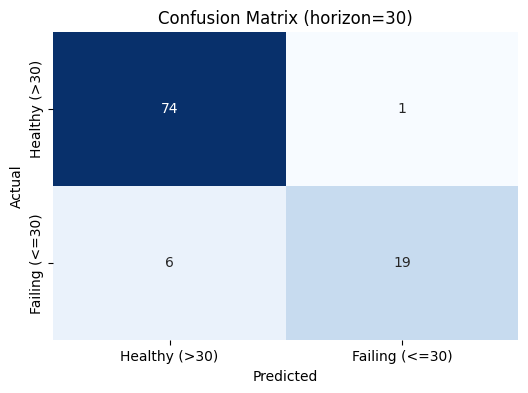

In [8]:
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
r2 = r2_score(y_test_lstm, y_pred_lstm)

print(f"RMSE: {rmse:.2f}, \nMAE: {mae:.2f}, \nR²: {r2:.2f}, \nAccuracy (%): {r2*100:.2f}")

# NASA Score
def nasa_score(y_true, y_pred):
    score = 0
    d = y_pred - y_true
    for d_i in d:
        if d_i < 0:
            score += np.exp(-d_i / 13.0) - 1
        else:
            score += np.exp(d_i / 10.0) - 1
    return score

print(f"NASA Score: {nasa_score(y_test_lstm, y_pred_lstm):.2f}")

# Classification framing
threshold = 30
y_test_class = (y_test_lstm <= threshold).astype(int)
y_pred_class = (y_pred_lstm <= threshold).astype(int)

print("\nClassification Report (horizon=30):")
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Healthy (>30)","Failing (<=30)"],
            yticklabels=["Healthy (>30)","Failing (<=30)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (horizon={threshold})")
plt.show()

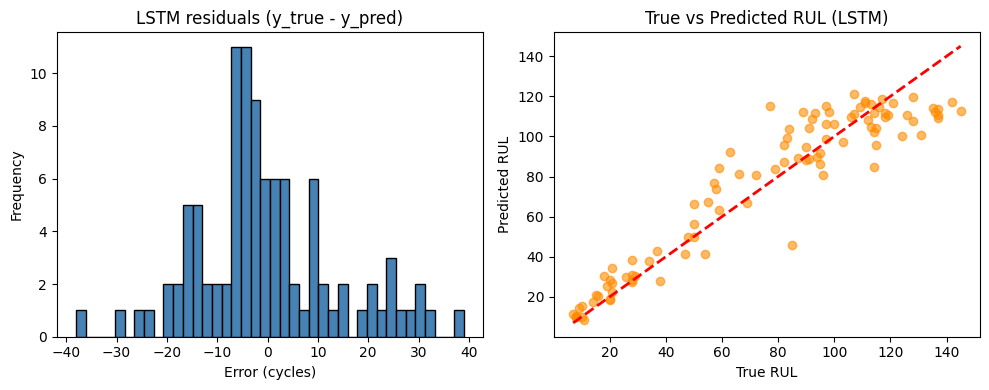

In [9]:
# Residuals & True vs Predicted Plots
plt.figure(figsize=(10,4))

# Residuals histogram
plt.subplot(1,2,1)
plt.hist((y_test_lstm - y_pred_lstm), bins=40, color="steelblue", edgecolor="black")
plt.title('LSTM residuals (y_true - y_pred)')
plt.xlabel('Error (cycles)')
plt.ylabel('Frequency')

# True vs Predicted scatter
plt.subplot(1,2,2)
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.6, color="darkorange")
plt.plot([y_test_lstm.min(), y_test_lstm.max()],
         [y_test_lstm.min(), y_test_lstm.max()], 'r--', lw=2)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted RUL (LSTM)')

plt.tight_layout()
plt.show()


# **8. Save Model and Scaler**

In [10]:
import joblib

# Save trained LSTM model
model_path = "lstm_rul_model.h5"
lstm_model.save(model_path)
print(f"✅ Model saved to {model_path}")

# Save fitted scaler
scaler_path = "scaler_lstm.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to {scaler_path}")


✅ Model saved to lstm_rul_model.h5
✅ Scaler saved to scaler_lstm.pkl


In [11]:
y_pred_lstm

array([108.3645  , 112.10659 ,  66.676346,  87.127075,  88.57516 ,
       111.47927 , 104.18529 ,  91.720184, 116.8675  ,  80.660484,
        98.53588 , 100.00295 ,  86.17612 , 111.311714,  98.99934 ,
       103.61125 ,  49.944546,  38.41028 ,  89.0565  ,  20.28715 ,
        76.814156, 117.55516 , 116.295494,  18.904833, 112.85154 ,
       110.46461 ,  81.05929 , 106.378296,  94.575966,  95.664055,
        10.107055,  49.912327, 109.56783 ,  11.624477,   8.578896,
        25.23009 ,  34.16631 ,  56.228676, 116.99625 ,  27.61901 ,
        30.40829 ,  15.436706,  63.20055 , 114.450165,  84.60703 ,
        41.422966, 114.3284  , 108.53362 ,  22.391489,  83.6047  ,
       102.04661 ,  30.521166,  30.093908, 115.016426, 110.73253 ,
        20.950735,  97.315926,  43.07941 , 111.85997 , 106.1703  ,
        26.709879,  41.170574,  80.63009 ,  30.723282, 119.62171 ,
        17.584375, 114.99168 ,  10.423751, 116.69348 ,  89.93885 ,
       111.68105 ,  66.04176 , 100.60261 , 110.829666, 104.753

In [12]:
y_test_lstm

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

# **9. Build & Train GRU Model**

In [13]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

gru_input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=gru_input_shape))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(64, return_sequences=True, activation='tanh'))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(units=32, activation='tanh'))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dense(1))

gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 128)        │        56,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,281 (411.25 KB)

 Trainable params: 105,281 (411.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
gru_model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [15]:
print("Training the GRU model...")
gru_history = gru_model.fit(X_train_lstm, y_train_lstm,
                           epochs=100,
                           batch_size=32,
                           validation_split=0.2,
                           callbacks=[early_stop],
                           verbose=2)
print("GRU model training complete.")

Training the GRU model...
Epoch 1/100
394/394 - 53s - 134ms/step - loss: 2660.5630 - root_mean_squared_error: 51.5806 - val_loss: 1841.0085 - val_root_mean_squared_error: 42.9070
Epoch 2/100
394/394 - 80s - 204ms/step - loss: 1758.8544 - root_mean_squared_error: 41.9387 - val_loss: 1846.3339 - val_root_mean_squared_error: 42.9690
Epoch 3/100
394/394 - 81s - 206ms/step - loss: 1767.9949 - root_mean_squared_error: 42.0475 - val_loss: 1850.0192 - val_root_mean_squared_error: 43.0118
Epoch 4/100
394/394 - 85s - 215ms/step - loss: 869.2861 - root_mean_squared_error: 29.4837 - val_loss: 268.4314 - val_root_mean_squared_error: 16.3839
Epoch 5/100
394/394 - 79s - 202ms/step - loss: 261.7671 - root_mean_squared_error: 16.1792 - val_loss: 149.6470 - val_root_mean_squared_error: 12.2330
Epoch 6/100
394/394 - 82s - 209ms/step - loss: 229.3049 - root_mean_squared_error: 15.1428 - val_loss: 152.1129 - val_root_mean_squared_error: 12.3334
Epoch 7/100
394/394 - 83s - 210ms/step - loss: 218.9523 - root

In [16]:
y_pred_gru = gru_model.predict(X_test_lstm)
y_pred_gru = y_pred_gru.flatten()
print("Predictions made on the test set using the GRU model.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
Predictions made on the test set using the GRU model.


In [17]:
rmse_gru = np.sqrt(mean_squared_error(y_test_lstm, y_pred_gru))
print(f"GRU Test RMSE: {rmse_gru:.2f}")

r2_gru = r2_score(y_test_lstm, y_pred_gru)
print(f"GRU Test R-squared Score: {r2_gru:.2f}")

nasa_score_gru = nasa_score(y_test_lstm, y_pred_gru)
print(f"GRU Test NASA Score: {nasa_score_gru:.2f}")

mae_gru = mean_absolute_error(y_test_lstm, y_pred_gru)
accuracy_percent_gru = r2_gru * 100
print("GRU Accuracy (%):", accuracy_percent_gru)
print("GRU MAE:", mae_gru)
print("GRU R2 Score:", r2_gru)

GRU Test RMSE: 13.49
GRU Test R-squared Score: 0.89
GRU Test NASA Score: 271.98
GRU Accuracy (%): 89.46713209152222
GRU MAE: 10.019450187683105
GRU R2 Score: 0.8946713209152222



Classification Report (horizon=30):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        75
           1       1.00      0.76      0.86        25

    accuracy                           0.94       100
   macro avg       0.96      0.88      0.91       100
weighted avg       0.94      0.94      0.94       100



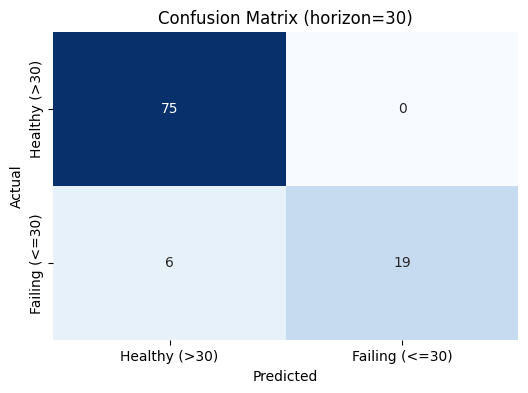

In [19]:
# Classification framing
threshold = 30
y_test_class = (y_test_lstm <= threshold).astype(int)
y_pred_class = (y_pred_gru <= threshold).astype(int)

print("\nClassification Report (horizon=30):")
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Healthy (>30)","Failing (<=30)"],
            yticklabels=["Healthy (>30)","Failing (<=30)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (horizon={threshold})")
plt.show()

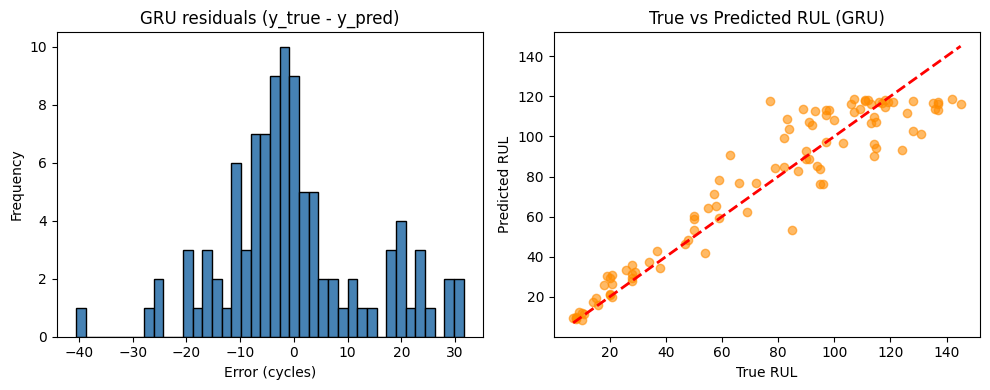

In [20]:
# Residuals & True vs Predicted Plots
plt.figure(figsize=(10,4))

# Residuals histogram
plt.subplot(1,2,1)
plt.hist((y_test_lstm - y_pred_gru), bins=40, color="steelblue", edgecolor="black")
plt.title('GRU residuals (y_true - y_pred)')
plt.xlabel('Error (cycles)')
plt.ylabel('Frequency')

# True vs Predicted scatter
plt.subplot(1,2,2)
plt.scatter(y_test_lstm, y_pred_gru, alpha=0.6, color="darkorange")
plt.plot([y_test_lstm.min(), y_test_lstm.max()],
         [y_test_lstm.min(), y_test_lstm.max()], 'r--', lw=2)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted RUL (GRU)')

plt.tight_layout()
plt.show()

In [18]:
gru_model.save("gru_rul_model.h5")
joblib.dump(scaler, "scaler_gru.pkl")

['scaler_gru.pkl']